In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from snntorch import spikegen
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
from spikingjelly.activation_based import functional
import pynvml  # For GPU power usage monitoring
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Initialize NVML for GPU power usage measurement
pynvml.nvmlInit()
gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)

def get_gpu_power_usage():
    return pynvml.nvmlDeviceGetPowerUsage(gpu_handle) / 1000  # in watts

# Global parameters
num_steps = 5
batch_size = 64
data_path = '/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data'

# Transformations for images
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_data = datasets.ImageFolder(root=f'{data_path}/train', transform=transform)
test_data = datasets.ImageFolder(root=f'{data_path}/test', transform=transform)

# Sampling for class balancing
targets = train_data.targets
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print('GPU available:', torch.cuda.is_available())  # Check if GPU is accessible

GPU available: True


In [2]:
# Define SNN with ResNet18 as encoder
def get_encoder_snn(in_channels: int):
    resnet = models.resnet18(pretrained=True)
    if in_channels != 3:
        resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    return resnet

class SNNModule(nn.Module):
    def __init__(self, in_channels, timesteps, n_classes):
        super(SNNModule, self).__init__()
        self.timesteps = timesteps
        self.encoder = get_encoder_snn(in_channels)
        self.fc = nn.Linear(1000, n_classes, bias=False)

    def forward(self, x):
        if x.dim() == 5:
            outputs = [self.encoder(x[t].to('cuda')) for t in range(x.shape[0])]
            x = torch.stack(outputs).mean(0)
        else:
            raise ValueError(f"Unexpected data shape: {x.shape}")
        functional.reset_net(self.encoder)
        x = torch.flatten(x, 1)
        return self.fc(x)

# Initialize model and transfer to GPU
snn_model = SNNModule(in_channels=1, timesteps=num_steps, n_classes=7).to('cuda')
optimizer = optim.Adam(snn_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training function with GPU power measurement
def entrainer_snn(train_loader, model, criterion, optimizer, num_epochs, num_steps):
    losses, accuracies, power_usages = [], [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        epoch_power_usage = 0.0

        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            spike_data = spikegen.rate(images.to('cuda'), num_steps=num_steps)  # Data on GPU
            output = model(spike_data)
            loss = criterion(output, labels.to('cuda'))  # Labels on GPU
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels.to('cuda')).sum().item()

            epoch_power_usage += get_gpu_power_usage()

            if (i + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        losses.append(epoch_loss)
        accuracies.append(epoch_accuracy)
        power_usages.append(epoch_power_usage)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Power: {epoch_power_usage:.4f} W")

    # Plot loss, accuracy, and power usage
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1); plt.plot(losses, label='Loss'); plt.legend(); plt.title("Loss over Epochs")
    plt.subplot(1, 3, 2); plt.plot(accuracies, label='Accuracy'); plt.legend(); plt.title("Accuracy over Epochs")
    plt.subplot(1, 3, 3); plt.plot(power_usages, label='Power Usage (W)'); plt.legend(); plt.title("GPU Power Usage")
    plt.show()


/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# Test function with GPU usage
def tester_snn(test_loader, model, num_steps):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            spike_data = spikegen.rate(images.to('cuda'), num_steps=num_steps)  # Data on GPU
            output = model(spike_data)
            _, predicted = torch.max(output, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_data.classes, yticklabels=train_data.classes)
    plt.xlabel("Prediction"); plt.ylabel("True"); plt.title("Confusion Matrix")
    plt.show()

Epoch [1/50], Step [10/449], Loss: 2.5412
Epoch [1/50], Step [20/449], Loss: 2.3995
Epoch [1/50], Step [30/449], Loss: 2.1025
Epoch [1/50], Step [40/449], Loss: 1.9676
Epoch [1/50], Step [50/449], Loss: 2.0769
Epoch [1/50], Step [60/449], Loss: 2.0749
Epoch [1/50], Step [70/449], Loss: 1.9034
Epoch [1/50], Step [80/449], Loss: 2.0047
Epoch [1/50], Step [90/449], Loss: 1.9492
Epoch [1/50], Step [100/449], Loss: 1.9041
Epoch [1/50], Step [110/449], Loss: 2.0266
Epoch [1/50], Step [120/449], Loss: 1.9108
Epoch [1/50], Step [130/449], Loss: 1.8919
Epoch [1/50], Step [140/449], Loss: 1.9528
Epoch [1/50], Step [150/449], Loss: 2.0657
Epoch [1/50], Step [160/449], Loss: 1.9487
Epoch [1/50], Step [170/449], Loss: 2.0066
Epoch [1/50], Step [180/449], Loss: 1.7760
Epoch [1/50], Step [190/449], Loss: 2.1354
Epoch [1/50], Step [200/449], Loss: 2.0409
Epoch [1/50], Step [210/449], Loss: 2.0986
Epoch [1/50], Step [220/449], Loss: 1.9507
Epoch [1/50], Step [230/449], Loss: 1.9554
Epoch [1/50], Step [

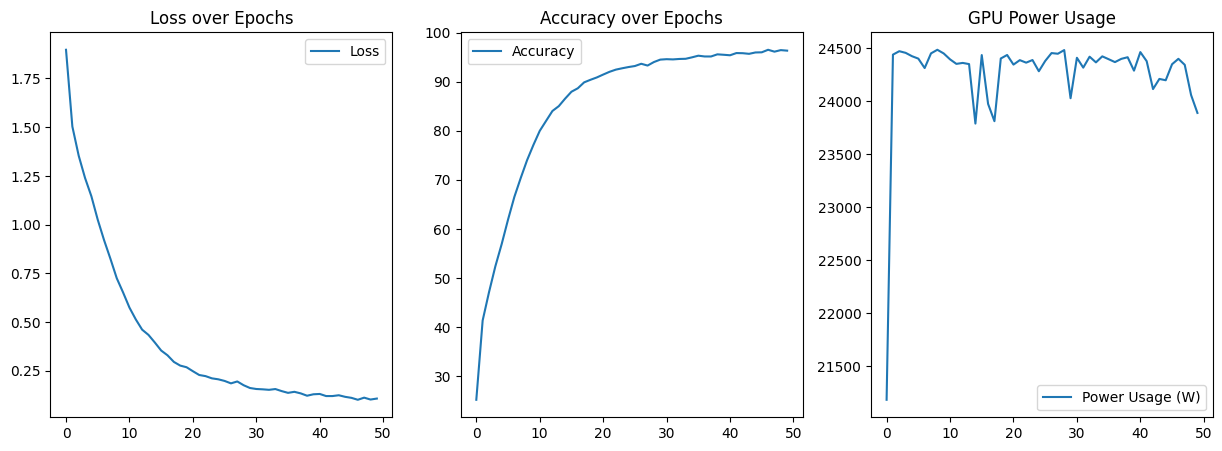

In [4]:
# Train model
entrainer_snn(train_loader, snn_model, criterion, optimizer, num_epochs=50, num_steps=num_steps)

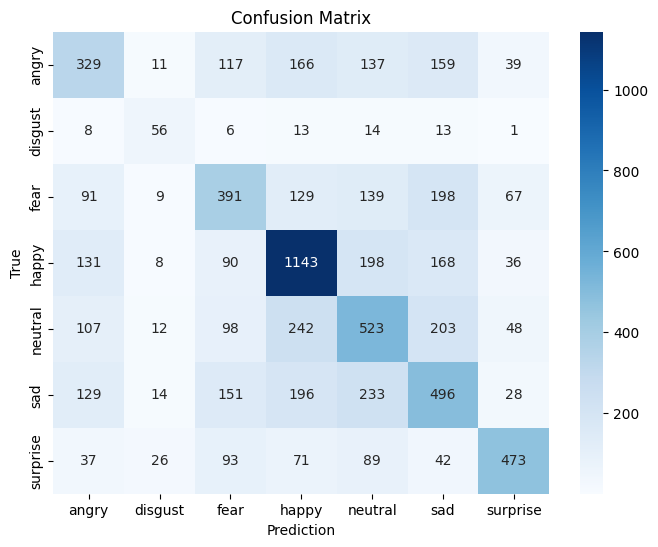

In [5]:
# Test model
tester_snn(test_loader, snn_model, num_steps)

# Free NVML resources
pynvml.nvmlShutdown()


In [6]:
# Save model
model_save_path = '/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/training/resultats/snn18_model.pth'
torch.save(snn_model.state_dict(), model_save_path)
print(f"Model saved at {model_save_path}")

# Reload model
snn_model_reloaded = SNNModule(in_channels=1, timesteps=num_steps, n_classes=7).to('cuda')
snn_model_reloaded.load_state_dict(torch.load(model_save_path))
snn_model_reloaded.eval()
print(f"Model reloaded from {model_save_path}")

Model saved at /home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/training/resultats/snn18_model.pth


/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model reloaded from /home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/training/resultats/snn18_model.pth


/tmp/ipykernel_8348/4000343352.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  snn_model_reloaded.load_state_dict(torch.load(model_save_path))


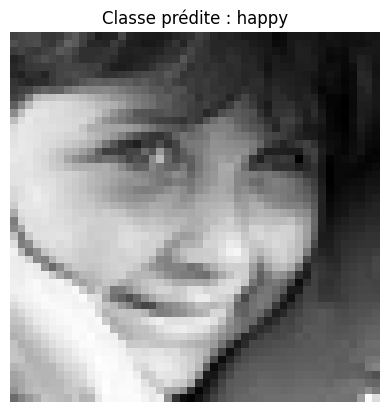

Classe prédite pour l'image : happy


In [7]:


import torch
from PIL import Image
import matplotlib.pyplot as plt
from snntorch import spikegen
from torchvision import transforms

# Fonction pour afficher l'image et la prédiction
def predire_et_afficher_image(image_path, model, num_steps, class_names):
    # Transformation pour préparer l'image
    transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))    
    ])

    # Charger et transformer l'image
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)  # Ajouter une dimension pour le batch

    # Encoder l'image en spikes
    spike_data = spikegen.rate(image_tensor, num_steps=num_steps)

    # Passer les spikes dans le modèle pour obtenir la prédiction
    with torch.no_grad():
        output = model(spike_data)
        _, prediction = torch.max(output, 1)
    
    predicted_class = class_names[prediction.item()]

    # Afficher l'image et la prédiction
    plt.imshow(image, cmap="gray")
    plt.title(f"Classe prédite : {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class

# Liste des noms de classes, dans l'ordre correspondant aux indices des labels
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Chemin vers l'image à tester
test_image_path = '/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data/test/happy/PrivateTest_258543.jpg'  # Remplacez par le chemin d'une image dans votre jeu de test

# Appeler la fonction pour afficher l'image et la prédiction
predicted_class = predire_et_afficher_image(test_image_path, snn_model_reloaded, num_steps, class_names)
print(f"Classe prédite pour l'image : {predicted_class}")
